In [2]:
import os
import json
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

import statsmodels.api as sm

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec 

from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import ART_statistic as ART_stat

import warnings
warnings.filterwarnings('ignore')

## Code to compare quantiles between original and correct

In [3]:
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'GSMaP', '3h'
product, time_reso = 'PERSIANN', '1dy'

BIAS = 'year'
# BIAS = 'all'

pixels = 5

In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

if product == 'SM2RAIN':
    yy_s, yy_e = 2007, 2012
    year_vector = np.arange(yy_s, yy_e+1)
else:
    yy_s, yy_e = 2002, 2012
    year_vector = np.arange(yy_s, yy_e+1)

years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [5]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : PERSIANN_1dy.json
Number of threads: 20
Neighborhood area: 5x5



In [6]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [7]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Veneto','BACKUP_RAW','VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    INFO_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [8]:
wa_pd = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto_INFO.csv'))
wa_pd = wa_pd[(wa_pd['YYS']<=yy_s)&(wa_pd['YYE']>=yy_e)]
wa_pd = wa_pd.reset_index()
wa_pd.head(5)

,index,File_Name,Lat,Lon,YYS,YYE,Elv,NY
0,0,002_FG_BS,45.895600,12.815000,1995,2022,21,28
1,1,003_BL_Ar,46.499984,11.876073,1984,2023,1642,40
2,2,003_FG_BS,45.918000,12.545000,1995,2022,22,28
3,3,004-264_NP_Be,46.164679,12.244708,1993,2023,379,31
4,5,008_FG_BS,45.805700,13.052600,1995,2022,5,28


## Define dataset for 80% and 20%

In [9]:
df_80 = wa_pd.sample(frac=0.8, random_state=42)
df_20 = wa_pd.drop(df_80.index)

print(f'Number of Stations: {len(wa_pd)}')
print(f'80% DataFrame: {len(df_80)}')
print(f'20% DataFrame: {len(df_20)}')

Number of Stations: 209
80% DataFrame: 167
20% DataFrame: 42


## Read the parameters for each station

In [10]:
total_years = np.arange(1980,2024)
N_array = np.zeros([len(df_80),len(total_years)])
C_array = np.zeros([len(df_80),len(total_years)])
W_array = np.zeros([len(df_80),len(total_years)])

for nn in range(len(df_80)):
    filename = f'{df_80['File_Name'].values[nn]}.csv'
    Weibull_data = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_data[Weibull_data['Year'] == YY]['N'].values
        C_ = Weibull_data[Weibull_data['Year'] == YY]['C'].values
        W_ = Weibull_data[Weibull_data['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

## Create OBS dataframes and extract the time period (exmpale: 2002, 2012)

In [39]:
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df['filename'] = df_80['File_Name'].values
N_df = N_df.loc[:,yy_s:yy_e]

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df['filename'] = df_80['File_Name'].values
C_df = C_df.loc[:,yy_s:yy_e]

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df['filename'] = df_80['File_Name'].values
W_df = W_df.loc[:,yy_s:yy_e]

## Load Satellite Downscale data

In [40]:
DATA = xr.open_dataset(os.path.join(dir_base,'Satellite','3_DOWN',f'VENETO_DOWN_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{pixels}.nc'))
lon = DATA.lon.values
lat = DATA.lat.values
lon2d, lat2d = np.meshgrid(lon, lat)

N_SAT = DATA.N.values
C_SAT = DATA.C.values
W_SAT = DATA.W.values

Q_SAT = DATA.Quantile.values

TR = DATA.Tr.values

## Aplly bias correction

In [41]:
N_NEW = np.zeros_like(N_SAT)
C_NEW = np.zeros_like(C_SAT)
W_NEW = np.zeros_like(W_SAT)

if BIAS == 'year':
    print(f'Apply correcion with year data')

    for count, YY in enumerate(np.arange(yy_s,yy_e+1)):
        NOBS_all = N_df[YY].values
        NOBS_all = NOBS_all[~np.isnan(NOBS_all)]
        COBS_all = C_df[YY].values
        COBS_all = COBS_all[~np.isnan(COBS_all)]
        WOBS_all = W_df[YY].values
        WOBS_all = WOBS_all[~np.isnan(WOBS_all)]

        N_tmp = ART_stat.ISIMIP_QM(NOBS_all, N_SAT[count,:,:].flatten())
        N_NEW[count,:,:] = N_tmp.reshape(N_SAT.shape[1],N_SAT.shape[2])

        C_tmp = ART_stat.ISIMIP_QM(COBS_all, C_SAT[count,:,:].flatten())
        C_NEW[count,:,:] = C_tmp.reshape(C_SAT.shape[1],C_SAT.shape[2])

        W_tmp = ART_stat.ISIMIP_QM(WOBS_all, W_SAT[count,:,:].flatten())
        W_NEW[count,:,:] = W_tmp.reshape(W_SAT.shape[1],W_SAT.shape[2])

elif BIAS == 'all':
    print(f'Apply correcion with all data')

    NOBS_all = N_df.values.flatten()
    COBS_all = C_df.values.flatten()
    WOBS_all = W_df.values.flatten()

    NOBS_all = NOBS_all[~np.isnan(NOBS_all)]
    COBS_all = COBS_all[~np.isnan(COBS_all)]
    WOBS_all = WOBS_all[~np.isnan(WOBS_all)]
    
    for i in range(len(lat)):
        for j in range(len(lon)):
            N_NEW[:,i,j] = ART_stat.ISIMIP_QM(NOBS_all, N_SAT[:,i,j].flatten())
            C_NEW[:,i,j] = ART_stat.ISIMIP_QM(COBS_all, C_SAT[:,i,j].flatten())
            W_NEW[:,i,j] = ART_stat.ISIMIP_QM(WOBS_all, W_SAT[:,i,j].flatten())

Apply correcion with year data


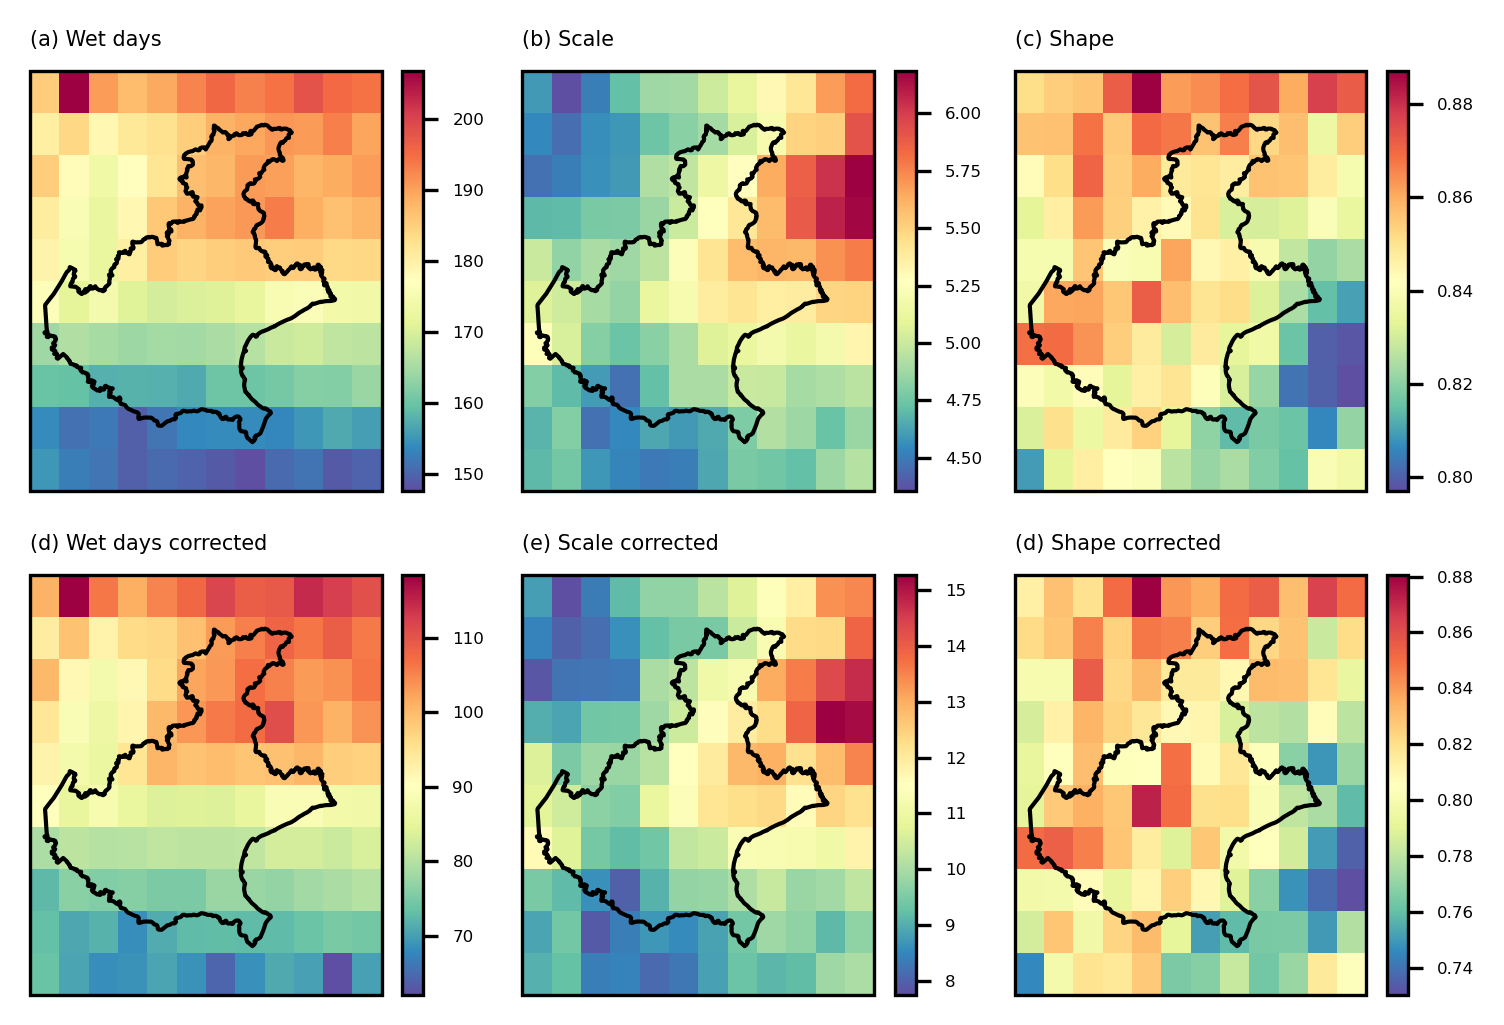

In [42]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(N_SAT,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(a) Wet days', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C_SAT,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(b) Scale', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W_SAT,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(c) Shape', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(N_NEW,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(d) Wet days corrected', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C_NEW,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(e) Scale corrected', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W_NEW,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(d) Shape corrected', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

## Compute Quantiles

In [43]:
Tr = [10, 20, 50, 100, 200]
Q_SAT = ART_down.pre_quantiles_array(N_SAT, C_SAT, W_SAT, Tr, lat, lon, 1)
Q_NEW = ART_down.pre_quantiles_array(N_NEW, C_NEW, W_NEW, Tr, lat, lon, 1)

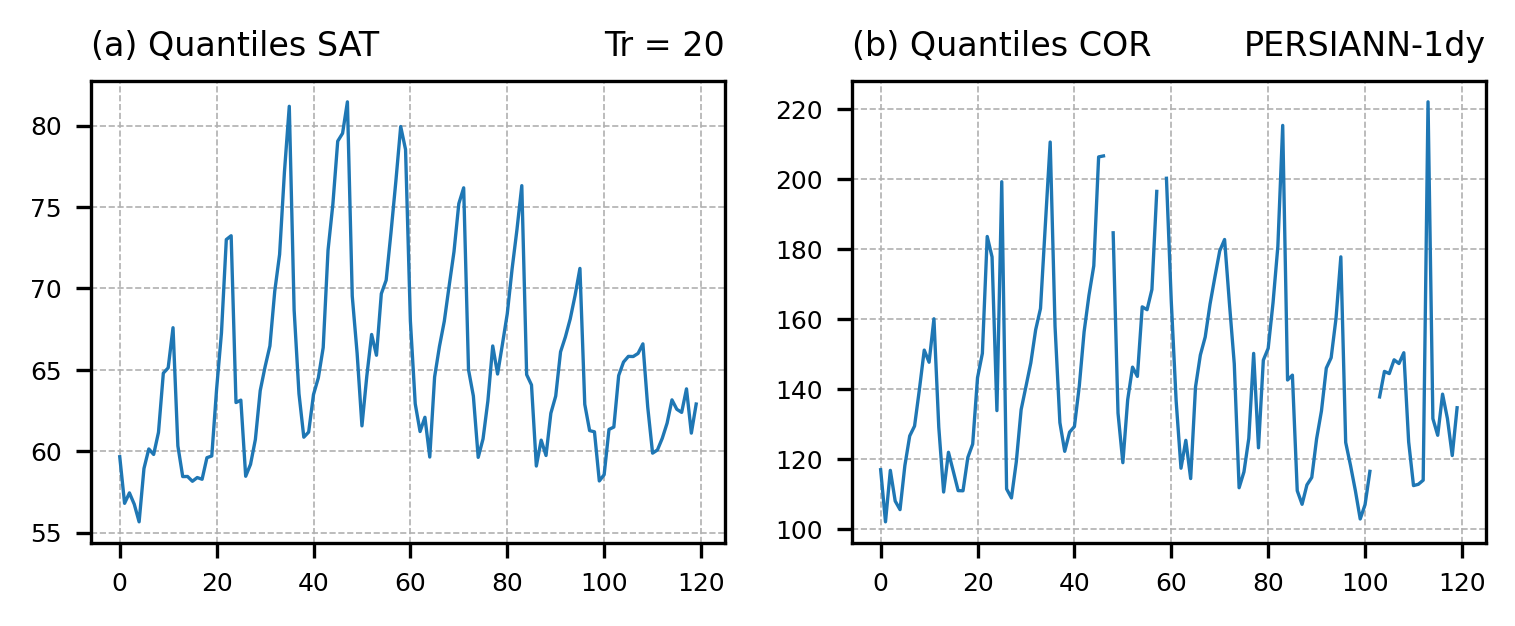

In [55]:
tr_pos = 1

fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(Q_SAT[tr_pos,:,:].flatten(),linewidth=0.8)
ax1.grid(linewidth=0.4, linestyle='--')
ax1.set_title(f'(a) Quantiles SAT', loc='left', fontsize=8)
ax1.set_title(f'Tr = {Tr[tr_pos]}', loc='right', fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=6)

ax1 = plt.subplot(gs[0, 1])
ax1.plot(Q_NEW[tr_pos,:,:].flatten(),linewidth=0.8)
ax1.grid(linewidth=0.4, linestyle='--')
ax1.set_title(f'(b) Quantiles COR', loc='left', fontsize=8)
ax1.set_title(f'{product}-{time_reso}', loc='right', fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=6)


In [56]:
if product == 'IMERG':
    Q_NEW[1,:,:][Q_NEW[1,:,:]>=300]=np.nan
    Q_NEW[2,:,:][Q_NEW[2,:,:]>=350]=np.nan
    Q_NEW[3,:,:][Q_NEW[3,:,:]>=400]=np.nan
elif product == 'CMORPH' and BIAS == 'all':
    Q_NEW[1,:,:][Q_NEW[1,:,:]>=200]=np.nan
    Q_NEW[2,:,:][Q_NEW[2,:,:]>=250]=np.nan
    Q_NEW[3,:,:][Q_NEW[3,:,:]>=400]=np.nan
elif product == 'MSWEP':
    Q_NEW[1,:,:][Q_NEW[1,:,:]>=500]=np.nan
    Q_NEW[2,:,:][Q_NEW[2,:,:]>=800]=np.nan
    Q_NEW[3,:,:][Q_NEW[3,:,:]>=1000]=np.nan
elif product == 'ERA5':
    Q_NEW[1,:,:][Q_NEW[1,:,:]>=300]=np.nan
    Q_NEW[2,:,:][Q_NEW[2,:,:]>=600]=np.nan
    Q_NEW[3,:,:][Q_NEW[3,:,:]>=750]=np.nan
elif product == 'GSMaP':
    Q_NEW[1,:,:][Q_NEW[1,:,:]>=400]=np.nan
    Q_NEW[2,:,:][Q_NEW[2,:,:]>=400]=np.nan
    Q_NEW[3,:,:][Q_NEW[3,:,:]>=600]=np.nan
elif product == 'PERSIANN':
    Q_NEW[1,:,:][Q_NEW[1,:,:]>=250]=np.nan
    Q_NEW[2,:,:][Q_NEW[2,:,:]>=350]=np.nan
    Q_NEW[3,:,:][Q_NEW[3,:,:]>=500]=np.nan

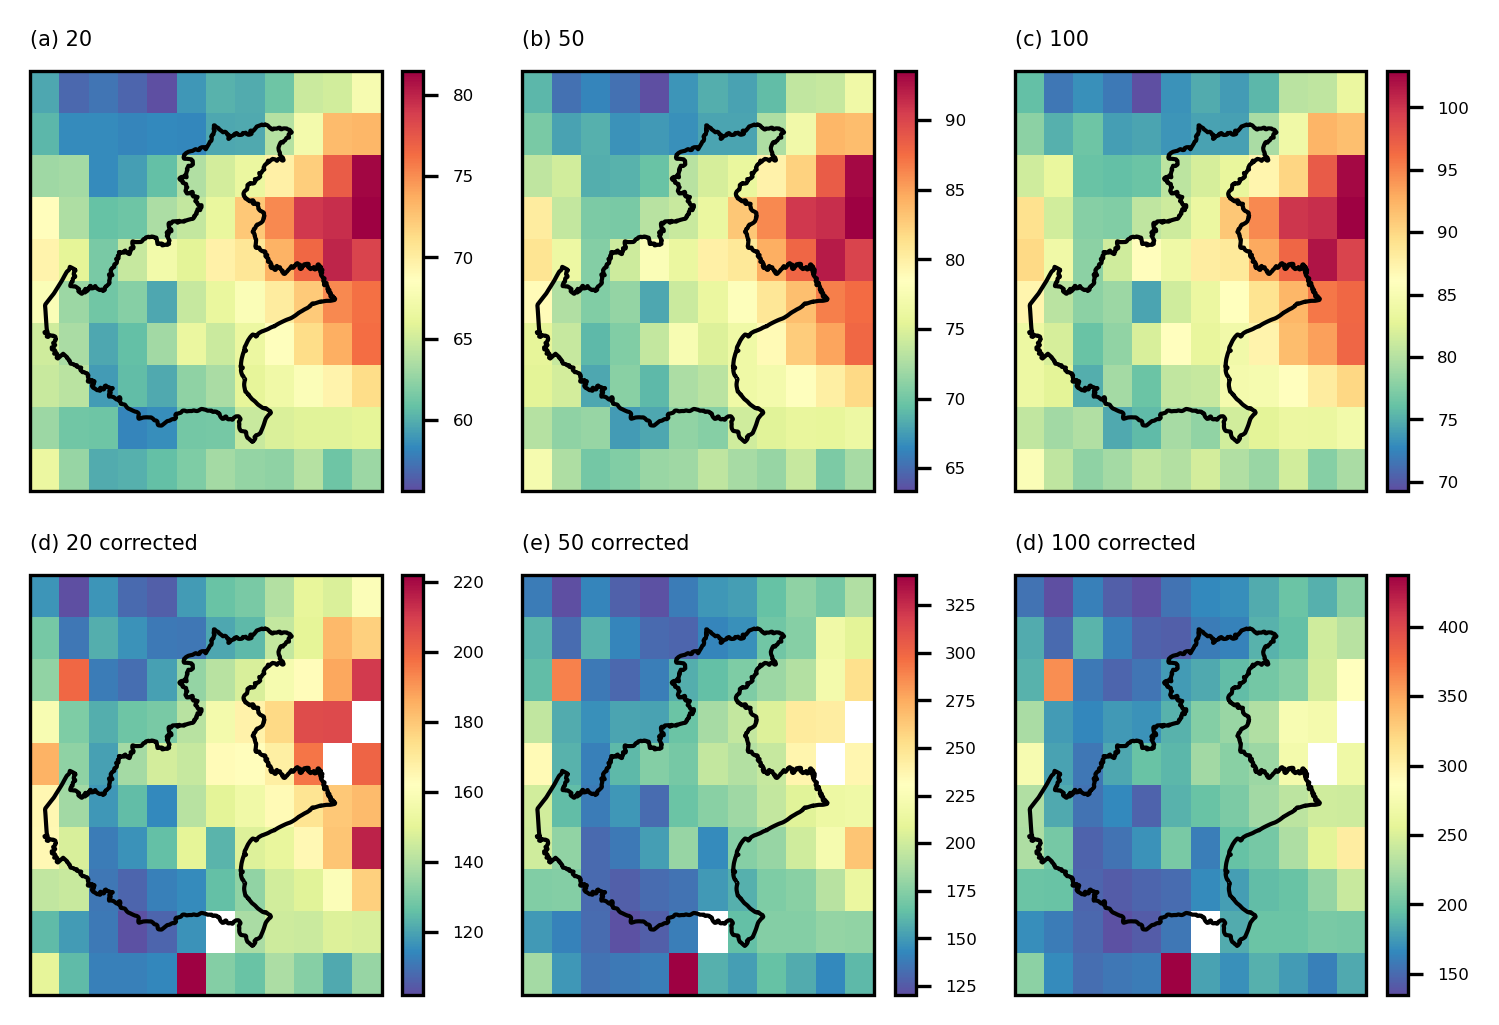

In [57]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_SAT[1,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(a) 20', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_SAT[2,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(b) 50', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_SAT[3,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(c) 100', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_NEW[1,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(d) 20 corrected', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_NEW[2,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(e) 50 corrected', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_NEW[3,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)
ax1.set_title(f'(d) 100 corrected', fontsize=5, loc='left')
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

In [58]:
ERROR1 = []
ERROR2 = []
Q_S = []
Q_O = []
Q_C = []

Fi = 1 - 1/np.array(Tr)
Fi = np.asarray(Fi)

for nn in range(len(df_80)):#len(wa_pd)
    lat_obs = float(df_80['Lat'].values[nn])
    lon_obs = float(df_80['Lon'].values[nn])

    Q_OBS, flag = ART_down.mev_quant(
                    Fi, 
                    90, 
                    N_df.iloc[nn].values, 
                    C_df.iloc[nn].values, 
                    W_df.iloc[nn].values, thresh=1)
    Q_OBS = Q_OBS[flag]
    
    if len(Q_OBS[Q_OBS>400]) >= 1:
        continue

    else:
        
        distances = ART_pre.haversine(lon2d, lat2d, lon_obs, lat_obs)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

        IMERG_val = float(Q_SAT[2,min_index[0],min_index[1]])
        CORRE_val = float(Q_NEW[2,min_index[0],min_index[1]])

        ER1_ = float((IMERG_val-Q_OBS[2])/Q_OBS[2])
        ER2_ = float((CORRE_val-Q_OBS[2])/Q_OBS[2])
        
        ERROR1.append(ER1_)
        ERROR2.append(ER2_)

        Q_S.append(IMERG_val)
        Q_C.append(CORRE_val)
        Q_O.append(Q_OBS[2])
        

In [59]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple']

Text(1.0, 1.0, '2002 to 2012')

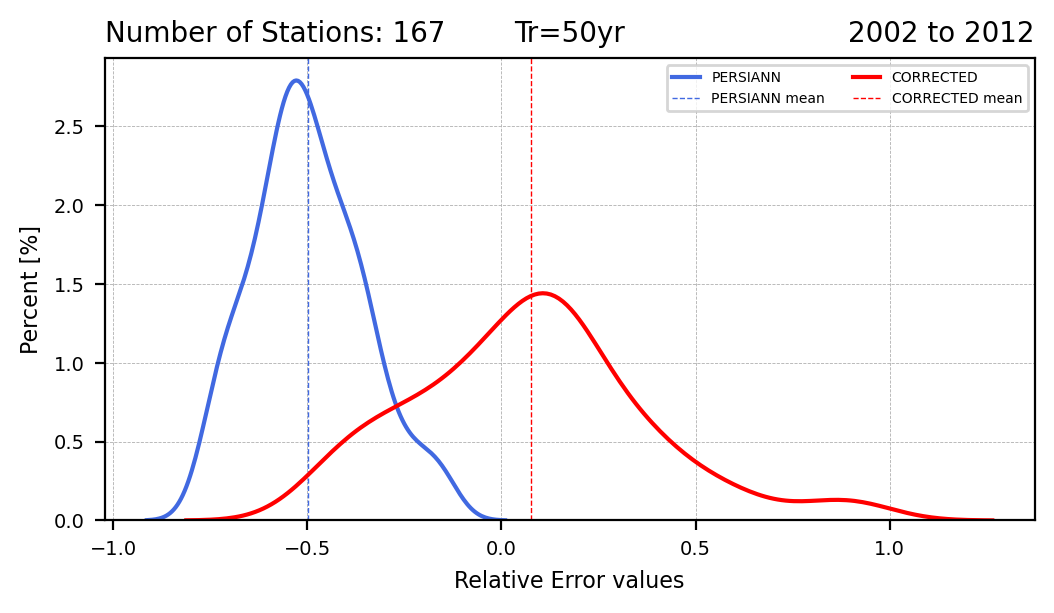

In [60]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])


sns.kdeplot(ERROR1,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'{product}')
ax1.axvline(np.nanmean(ERROR1), color=colors[0], linestyle='--', linewidth=0.5, label=f'{product} mean')

sns.kdeplot(ERROR2,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CORRECTED')
ax1.axvline(np.nanmean(ERROR2), color=colors[1], linestyle='--', linewidth=0.5, label='CORRECTED mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'Number of Stations: {len(df_80)}', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[2]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

Text(0.0, 1.0, '(b) Quantiles PERSIANN Corrected')

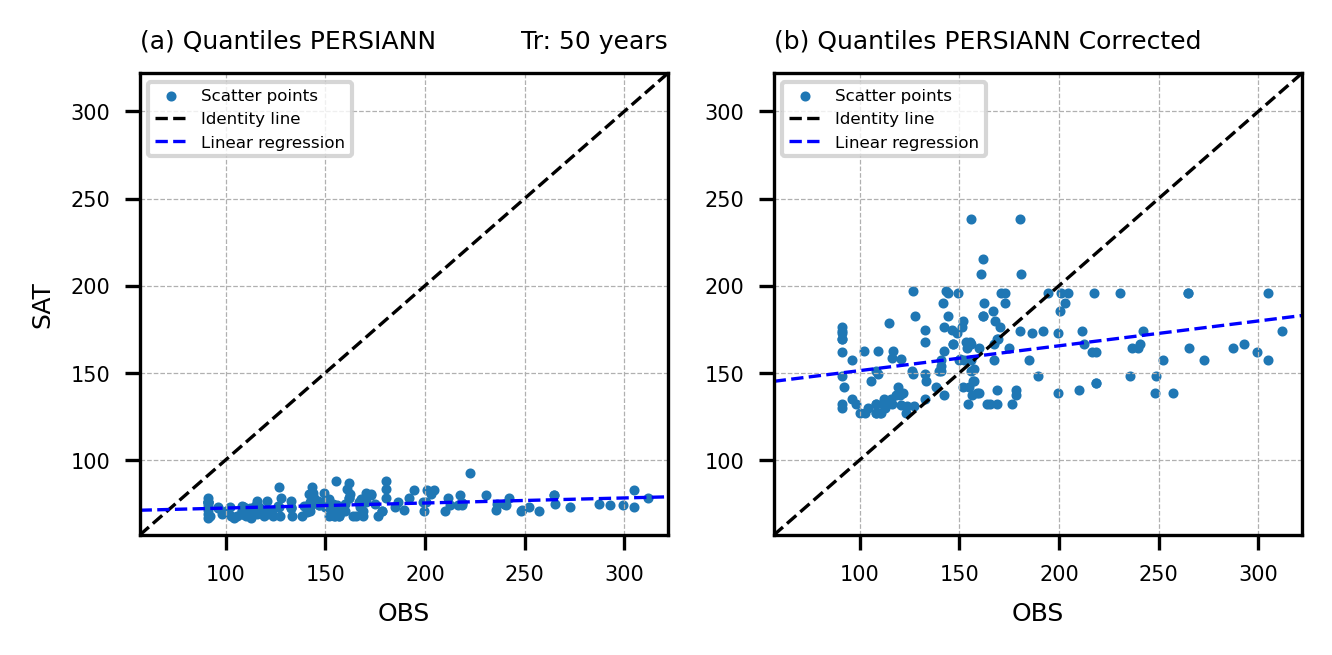

In [61]:
fig = plt.figure(figsize=(5,2),dpi=300)
gs = gridspec.GridSpec(1,2)

max_val = np.max([
                np.nanmax(Q_O),
                np.nanmax(Q_S),
                np.nanmax(Q_C)])+10
min_val = np.min([
                np.nanmin(Q_O),
                np.nanmin(Q_S),
                np.nanmin(Q_C)])-10

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(Q_O, Q_S, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(Q_O, Q_S)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('SAT', fontsize=6)

ax1.set_title(f'(a) Quantiles {product}', fontsize=6, loc='left')
ax1.set_title(f'Tr: 50 years', fontsize=6, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(Q_O, Q_C, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(np.array(Q_O)[~np.isnan(np.array(Q_C))], np.array(Q_C)[~np.isnan(np.array(Q_C))])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_xlabel('OBS', fontsize=6)

ax1.set_title(f'(b) Quantiles {product} Corrected', fontsize=6, loc='left')

In [62]:
percs = np.linspace(0,100,61)
x = np.linspace(40,390)

qn_OBS = np.percentile(Q_O, percs)
qn_IMERG = np.percentile(Q_S, percs)
qn_IMERG_correct = np.nanpercentile(Q_C, percs)

Text(0.5, 0, 'OBS quantiles')

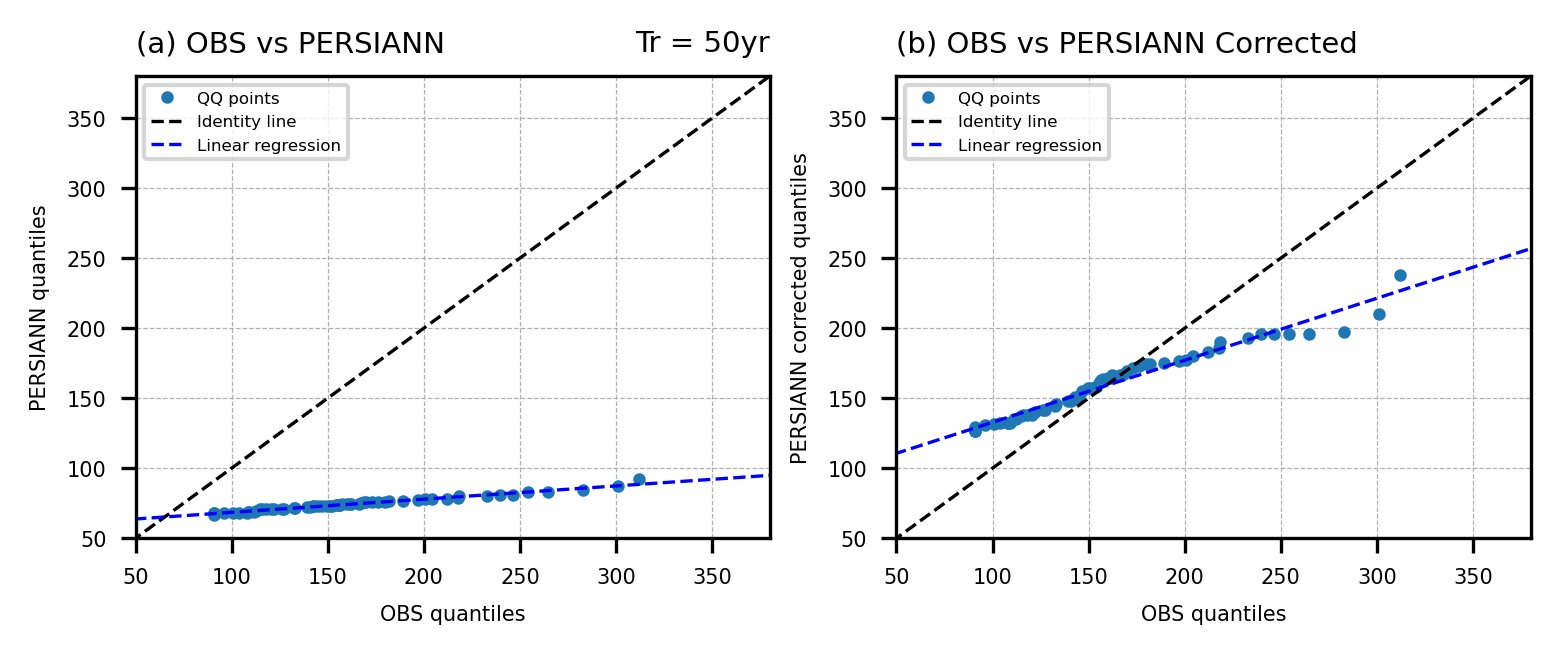

In [63]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(qn_OBS,qn_IMERG, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(qn_OBS,qn_IMERG)
y_pred = slope * x + intercept
ax1.plot(x,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title(f'(a) OBS vs {product}', fontsize=7, loc='left')
ax1.set_title('Tr = 50yr', fontsize=7, loc='right')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(50,380)
ax1.set_xlim(50,380)
ax1.legend(fontsize=4)
ax1.set_ylabel(f'{product} quantiles', fontsize=5)
ax1.set_xlabel('OBS quantiles', fontsize=5)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])

ax1.plot(qn_OBS,qn_IMERG_correct, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(qn_OBS,qn_IMERG_correct)
y_pred = slope * x + intercept
ax1.plot(x,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title(f'(b) OBS vs {product} Corrected', fontsize=7, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(50,380)
ax1.set_xlim(50,380)
ax1.legend(fontsize=4)
ax1.set_ylabel(f'{product} corrected quantiles', fontsize=5)
ax1.set_xlabel('OBS quantiles', fontsize=5)

## Compare to the remaining 20%